In [98]:
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, SpectralClustering, DBSCAN, OPTICS, Birch, HDBSCAN, AffinityPropagation
from sklearn.datasets import make_blobs, make_moons, make_circles

%matplotlib inline

In [2]:
sns.set_style("dark")

# Synthetic data for clustering

In [4]:
X_circle, _ = make_circles(n_samples=80, noise=0.1, random_state=42)
addition_matrix = np.zeros((X_circle.shape[0], X_circle.shape[1]))
addition_matrix[:, 0] = 0.3
addition_matrix[:, 1] = -0.5
X_circle = X_circle + addition_matrix

X_moons, _ = make_moons(n_samples=160, noise=0.1, random_state=42)
addition_matrix = np.zeros((X_moons.shape[0], X_moons.shape[1]))
addition_matrix[:, 0] = 0.2
addition_matrix[:, 1] = 0.9
X_moons = X_moons + addition_matrix

X_blob, _ = make_blobs(n_samples=80, n_features=2, centers=[[-2.4, 0.1]], random_state=42)
X_aniso = np.matmul(X_blob, [[0.6, -0.3], [-0.7, 1.8]]) # anisotropicly distributed data

X_blob, _ = make_blobs(n_samples=160, n_features=2, centers=[[-2.4, -1], [1, 3]], 
                       random_state=42, cluster_std=0.5)

X_for_viz = np.vstack([X_circle, X_moons, X_aniso, X_blob])

In [9]:
plot_kwds = {'alpha': 0.40, 's': 80, 'linewidths': 1, 'edgecolor': 'white'}

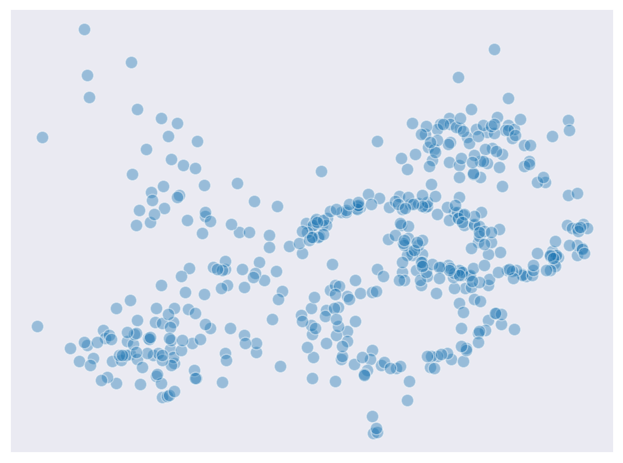

In [146]:
plt.scatter(X_for_viz[:, 0], X_for_viz[:, 1], **plot_kwds)

frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.savefig('../../assets/images/clustering/dataset_for_clustering.png', bbox_inches='tight');

In [7]:
def plot_clusters(data: np.ndarray, algorithms: list[tuple], figsize=None, axes_titles=None):
    """Make a plot with different clusters colored according to the output 
    of the provided clustering algorithm.

    ----------
    Parameters:
    algorithms : list
        It should contain a tuple with the algorithm itself and a dictionary with all of its keywords. 
    """
    if axes_titles is None:
        axes_titles = [''] * len(algorithms)
    
    fig = plt.figure(figsize=figsize)
        
    total_algorithms = len(algorithms)
    for i, algo in enumerate(algorithms, 1):
        ax = fig.add_subplot(1, total_algorithms, i)
        start_time = time.time()
        labels = algo[0](**algo[1]).fit_predict(data)
        end_time = time.time()
        algo_time = end_time - start_time
        
        palette = sns.color_palette('deep', np.unique(labels).size)
        colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
        ax.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

        ax.text(0.03, 0.05, f'Clustering took {algo_time:.2f} sec', transform=ax.transAxes, fontsize=9)
        if axes_titles[i-1]:
            ax.set_title(axes_titles[i-1])
        else:
            ax.set_title(f'Clusters found by {algo[0].__name__}')

    plt.tight_layout()

# K-means

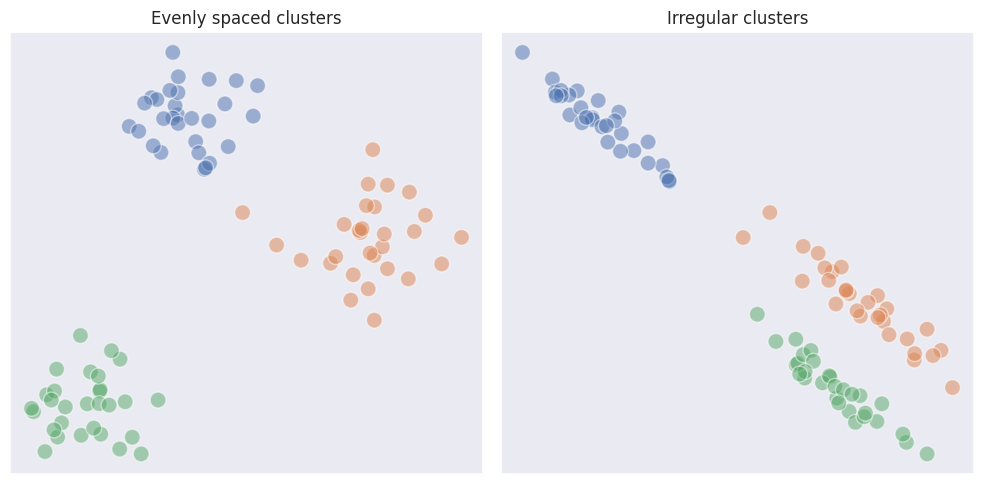

In [144]:
X, y = make_blobs(n_samples=87, cluster_std=[1.6, 2.0, 1.5], random_state=42)
X_aniso = np.matmul(X, [[0.6, -0.3], [-0.7, 0.8]]) # anisotropicly distributed data

kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
kmeans_aniso = KMeans(n_clusters=3, random_state=42).fit(X_aniso)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Evenly spaced clusters')
ax[1].set_title('Irregular clusters')

palette = sns.color_palette('deep', np.unique(y).size)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in y]
plot_kwds = {'alpha': 0.50, 's': 130, 'linewidths': 1, 'edgecolor': 'white'}

ax[0].scatter(X[:, 0], X[:, 1], c=colors, **plot_kwds)
ax[1].scatter(X_aniso[:, 0], X_aniso[:, 1], c=colors, **plot_kwds)

for ax in ax:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.savefig('../../assets/images/clustering/K_means_clustering.png', bbox_inches='tight');

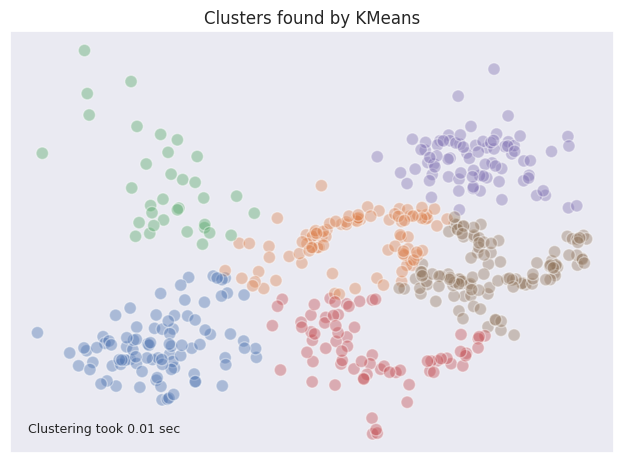

In [211]:
plot_kwds = {'alpha': 0.40, 's': 80, 'linewidths': 1, 'edgecolor': 'white'}

plot_clusters(
    X_for_viz, 
    [(KMeans, {'n_clusters': 6})]
)
plt.savefig('../../assets/images/clustering/K_means_clustering_test.png', bbox_inches='tight');

# Agglomerative

## With dendrogram

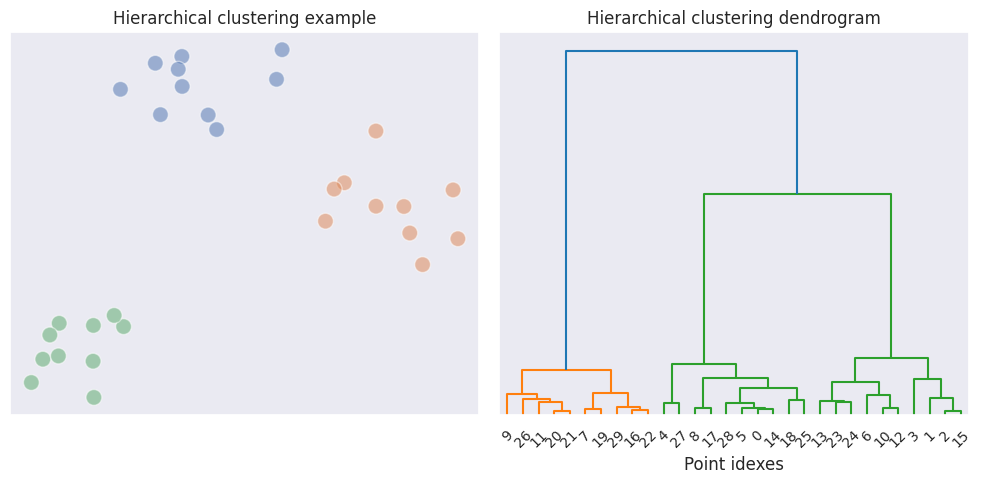

In [203]:
X, y = make_blobs(n_samples=30, cluster_std=[1.7, 2.0, 1.5], random_state=42)

def plot_dendrogram(model, **kwargs):
    '''Creates linkage matrix from the passed model and then plots the dendrogram'''
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
model = AgglomerativeClustering(n_clusters=3, linkage='ward', compute_distances=True)
model = model.fit(X)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Hierarchical clustering example')
#sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=model.labels_, palette='deep', alpha=0.8, ax=ax[0], legend=False, s=200)
palette = sns.color_palette('deep', np.unique(y).size)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in y]
plot_kwds = {'alpha': 0.50, 's': 130, 'linewidths': 1, 'edgecolor': 'white'}

ax[0].scatter(X[:, 0], X[:, 1], c=colors, **plot_kwds)

ax[1].set_title('Hierarchical clustering dendrogram')
plot_dendrogram(model, truncate_mode=None, ax=ax[1])
ax[1].set_xlabel('Point idexes')
ax[0].axes.get_xaxis().set_visible(False)
for ax in ax:
    ax.axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.savefig('../../assets/images/clustering/agglomerative_clustering.png', bbox_inches='tight');

## Different types of linkage

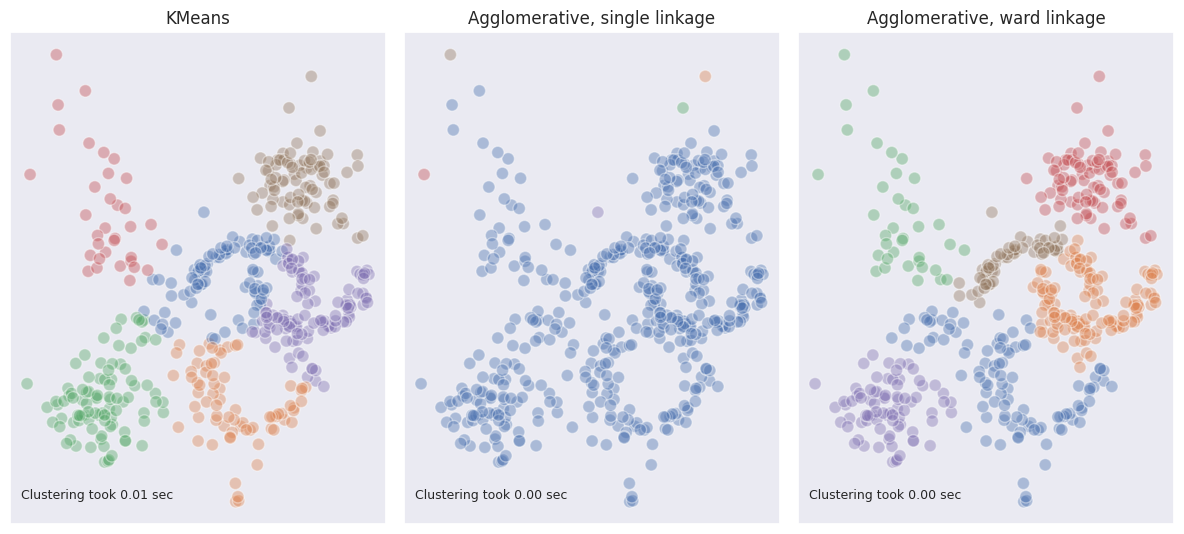

In [227]:
plot_clusters(
    X_for_viz, 
    [
        (KMeans, {'n_clusters': 6}),
        (AgglomerativeClustering, {'n_clusters': 6, 'linkage': 'single'}),
        (AgglomerativeClustering, {'n_clusters': 6, 'linkage': 'ward'}),
    ],
    figsize=(12, 5.5),
    axes_titles=['KMeans', 'Agglomerative, single linkage', 'Agglomerative, ward linkage']
)
plt.savefig('../../assets/images/clustering/agglomerative_linkage_comparison.png', bbox_inches='tight');

# Affinity propagation

In [6]:
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=300, centers=centers, cluster_std=0.5, random_state=0
)

In [7]:
af = AffinityPropagation(preference=-50, random_state=0).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

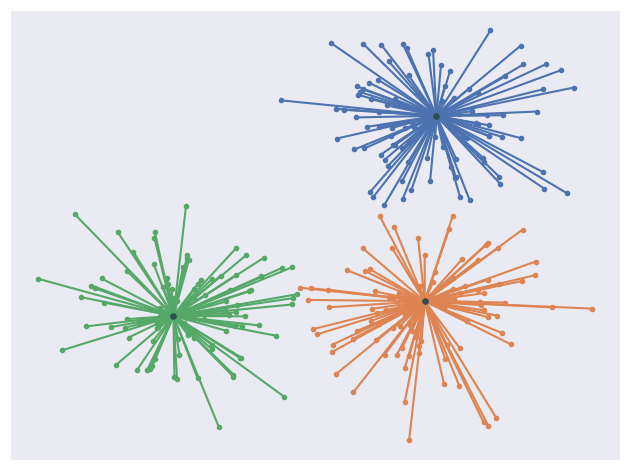

In [18]:
colors = sns.color_palette('deep')

for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.scatter(
        X[class_members, 0], X[class_members, 1], color=col, marker="."
    )
    plt.scatter(
        cluster_center[0], cluster_center[1], s=14, color='darkslategrey', marker="o", zorder=20
    )
    for x in X[class_members]:
        plt.plot(
            [cluster_center[0], x[0]], [cluster_center[1], x[1]], color=col
        )


frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.savefig('../../assets/images/clustering/affinity_propagation.png', bbox_inches='tight');

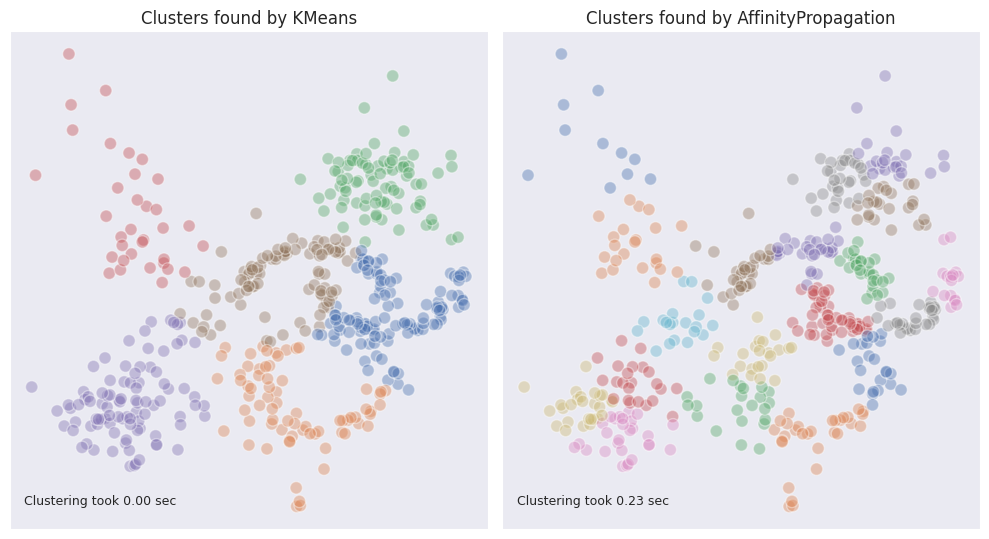

In [20]:
plot_kwds = {'alpha': 0.40, 's': 80, 'linewidths': 1, 'edgecolor': 'white'}

plot_clusters(
    X_for_viz, 
    [
        (KMeans, {'n_clusters': 6}),
        (AffinityPropagation, {}),
    ],
    figsize=(10, 5.5),
)
plt.savefig('../../assets/images/clustering/affinity_propagation_test.png', bbox_inches='tight');

# Mean shift

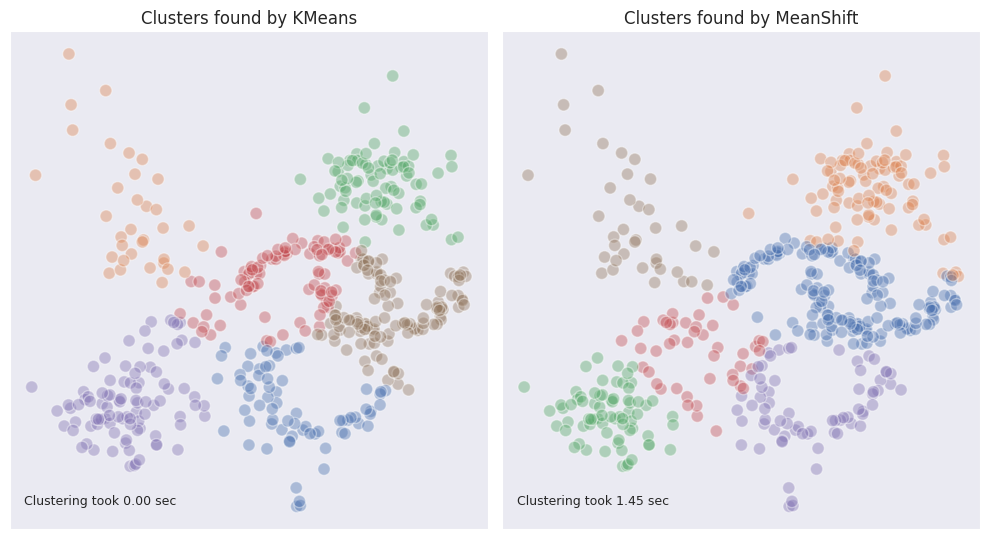

In [81]:
plot_clusters(
    X_for_viz, 
    [
        (KMeans, {'n_clusters': 6}),
        (MeanShift, {'bandwidth': 1.2}),
    ],
    figsize=(10, 5.5),
)
plt.savefig('../../assets/images/clustering/mean_shift_test.png', bbox_inches='tight');

# Spectral clustering

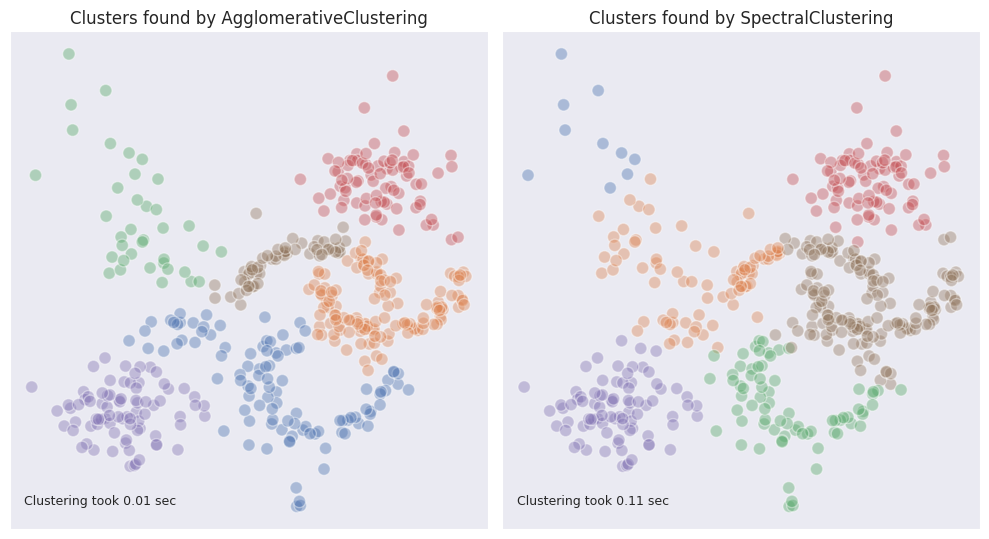

In [39]:
plot_clusters(
    X_for_viz, 
    [
        (AgglomerativeClustering, {'n_clusters': 6, 'linkage': 'ward'}),
        (SpectralClustering, {'n_clusters': 6, 'assign_labels': 'cluster_qr'}),
    ],
    figsize=(10, 5.5),
)
plt.savefig('../../assets/images/clustering/spectral_clustering_test.png', bbox_inches='tight');

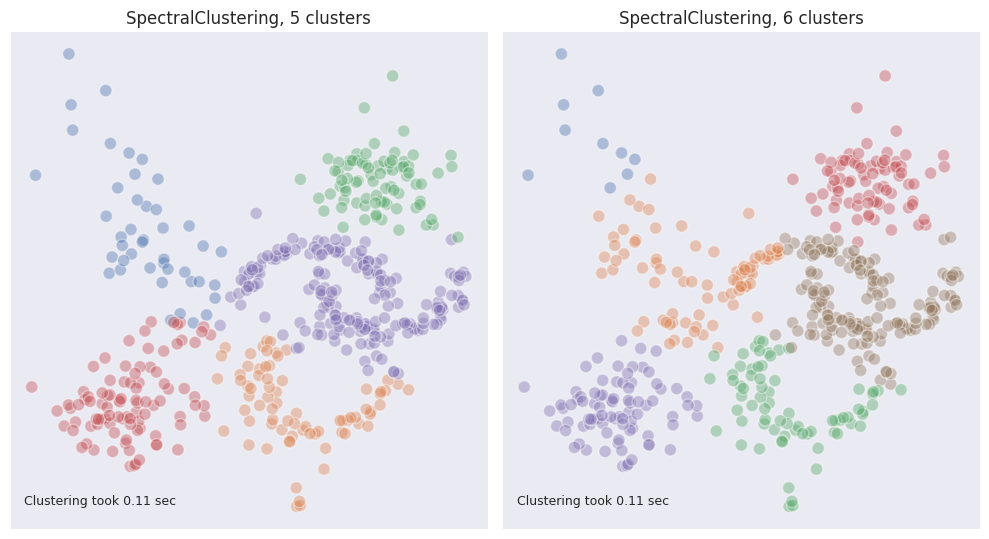

In [103]:
plot_clusters(
    X_for_viz, 
    [
        (SpectralClustering, {'n_clusters': 5, 'assign_labels': 'cluster_qr'}),
        (SpectralClustering, {'n_clusters': 6, 'assign_labels': 'cluster_qr'}),
    ],
    figsize=(10, 5.5),
    axes_titles=['SpectralClustering, 5 clusters', 'SpectralClustering, 6 clusters']
)
plt.savefig('../../assets/images/clustering/spectral_clustering_test_diff_cluster_n.png', bbox_inches='tight');

# DBSCAN

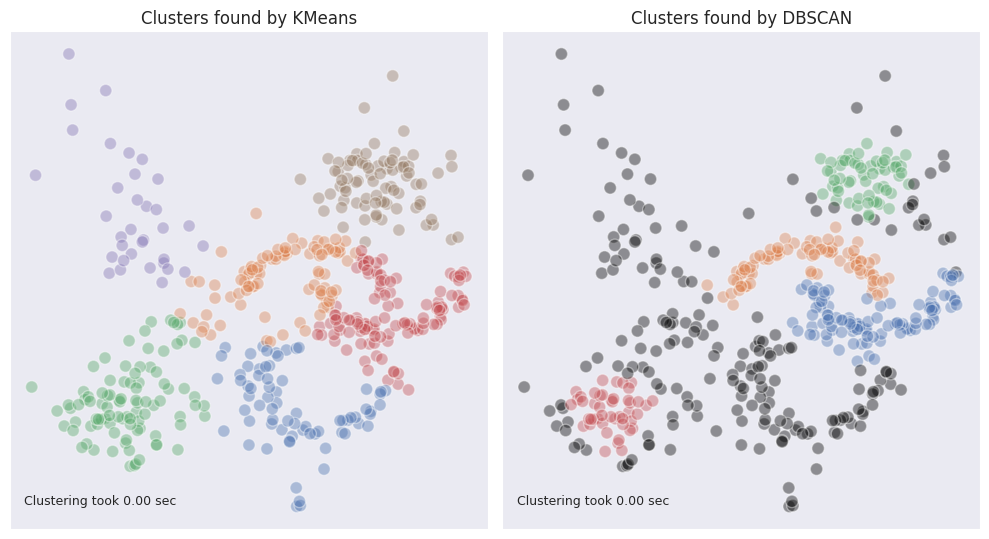

In [75]:
plot_clusters(
    X_for_viz, 
    [
        (KMeans, {'n_clusters': 6}),
        (DBSCAN, {'eps': 0.4, 'min_samples': 20}),
    ],
    figsize=(10, 5.5),
)
plt.savefig('../../assets/images/clustering/dbscan_test.png', bbox_inches='tight');

# OPTICS

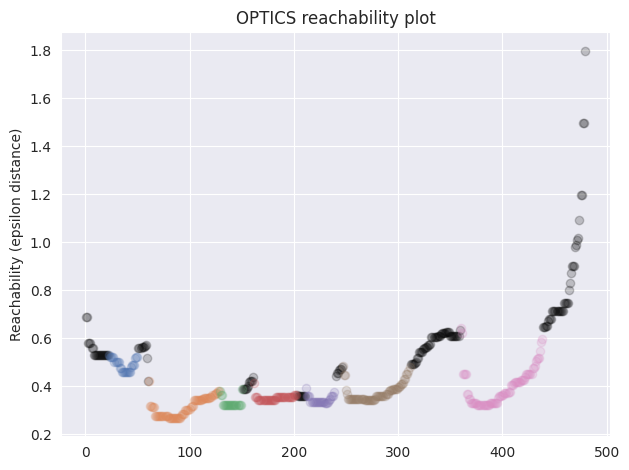

In [17]:
clust = OPTICS(min_samples=20, xi=0.0)

# Run the fit
clust.fit(X_for_viz)

space = np.arange(len(X_for_viz))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots()

palette = sns.color_palette('deep', np.unique(labels).size)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in np.unique(labels)]

for klass, color in zip(np.unique(labels), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax.scatter(Xk, Rk, color=color, alpha=0.2)

ax.set_title("OPTICS reachability plot")
ax.set_ylabel("Reachability (epsilon distance)")
plt.tight_layout()
plt.savefig('../../assets/images/clustering/optics_reachability.png', bbox_inches='tight');

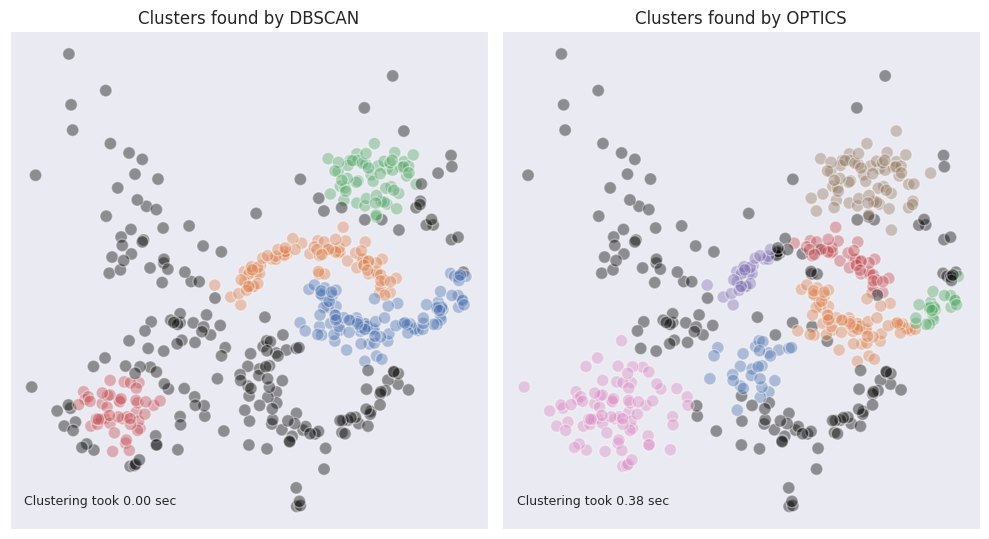

In [16]:
plot_clusters(
    X_for_viz, 
    [
        (DBSCAN, {'eps': 0.4, 'min_samples': 20}),
        (OPTICS, {'min_samples': 20, 'xi': 0.0, 'max_eps': np.inf}),
    ],
    figsize=(10, 5.5),
)
plt.savefig('../../assets/images/clustering/optics_test.png', bbox_inches='tight');

# Birch

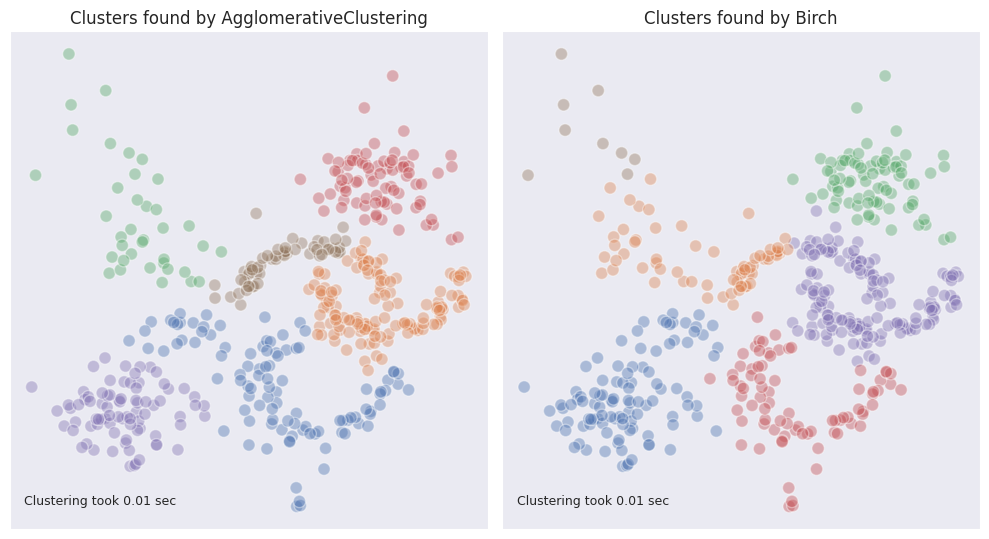

In [51]:
plot_clusters(
    X_for_viz, 
    [
        (AgglomerativeClustering, {'n_clusters': 6, 'linkage': 'ward'}),
        (Birch, {'n_clusters': None, 'branching_factor': 50, 'threshold': 0.3, 'n_clusters': 6}),
    ],
    figsize=(10, 5.5),
)
plt.savefig('../../assets/images/clustering/birch_test.png', bbox_inches='tight');

# HDBSCAN

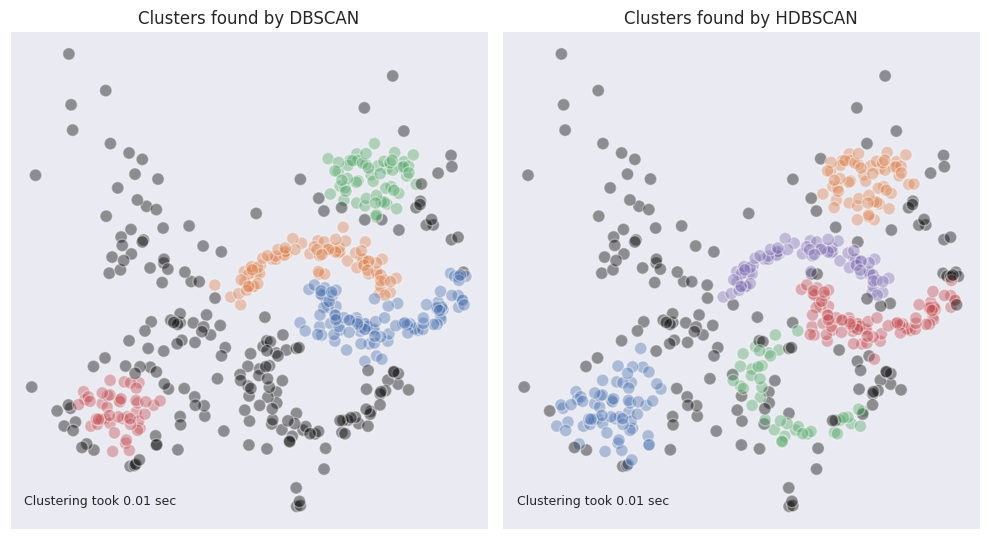

In [137]:
plot_clusters(
    X_for_viz, 
    [
        (DBSCAN, {'eps': 0.4, 'min_samples': 20}),
        (HDBSCAN, {'min_samples': 10, 'min_cluster_size': 20}),
    ],
    figsize=(10, 5.5),
)
plt.savefig('../../assets/images/clustering/hdbscan_test.png', bbox_inches='tight');